In [1]:
# Mount the Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# install torchvison
!pip -q install vit_pytorch linformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.2 MB/s eta 0:00:00


In [3]:
# Install the Cleverhans library (provides adversarial attacks)
!pip install -qq git+http://github.com/tensorflow/cleverhans.git#egg=cleverhans

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.0 MB/s eta 0:00:00


In [4]:
# import libraries

# os interface
import os

# data processing libraries
import numpy as np
import matplotlib.pyplot as plt
import csv

# python image library
from PIL import Image

# torch package
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.optim as optim

# torchvision
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchvision.utils import save_image

# wrap an iterable object into tqdm
from tqdm.notebook import tqdm


from vit_pytorch.efficient import ViT
from linformer import Linformer

# Import PGD attack
import cleverhans
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Dataset Loading

In [6]:
# Download the dataset
!wget https://www.webpages.uidaho.edu/vakanski/Codes_Data/LFW-dataset.zip

--2024-02-28 05:39:10--  https://www.webpages.uidaho.edu/vakanski/Codes_Data/LFW-dataset.zip
Resolving www.webpages.uidaho.edu (www.webpages.uidaho.edu)... 129.101.105.230
Connecting to www.webpages.uidaho.edu (www.webpages.uidaho.edu)|129.101.105.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12467105 (12M) [application/x-zip-compressed]
Saving to: ‘LFW-dataset.zip’

LFW-dataset.zip     100%[===================>]  11.89M  4.31MB/s    in 2.8s    

2024-02-28 05:39:14 (4.31 MB/s) - ‘LFW-dataset.zip’ saved [12467105/12467105]



In [7]:
# Uncompress the dataset
!unzip -uq 'LFW-dataset.zip' -d 'sample_data/'

In [8]:
# Define a function for loading the dataset
class Dataset_LFW(Dataset):
    def __init__(self, root_dir, transform, folder_name):
        super().__init__()
        # get the location of the images
        self.image_folder = os.path.join(root_dir, folder_name)

        # load the label file into label_name
        self.labels_name = np.genfromtxt(root_dir + folder_name + "_labels.csv", delimiter=',', dtype=np.int32)

        self.transform = transform

    def __len__(self):
        return len(self.labels_name)

    def __getitem__(self, idx):

        # open idx_th image
        img_name = os.path.join(self.image_folder, f'img_{idx + 1:04}.jpg')
        image = Image.open(img_name)
        image = self.transform(image)

        # get label of idx_th image
        label = self.labels_name[idx]
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [9]:
# Define the transform to preprocess the data
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224 x 224 pixels
    transforms.ToTensor(),  # Convert the images to a PyTorch tensor
])

In [10]:
# Download the train, test, and validation datasets
train_dataset = Dataset_LFW(root_dir='sample_data/LFW-dataset/', transform=transform, folder_name='train')
test_dataset = Dataset_LFW(root_dir='sample_data/LFW-dataset/', transform=transform, folder_name='test')
val_dataset = Dataset_LFW(root_dir='sample_data/LFW-dataset/', transform=transform, folder_name='validation')

In [11]:
# Check the datasets
print('Train dataset length:', len(train_dataset))
print('Test dataset length:', len(test_dataset))
print('Validation dataset length:', len(val_dataset))

Train dataset length: 3043
Test dataset length: 1049
Validation dataset length: 1021


In [12]:
# Create dataloaders to iterate over the datasets
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=64)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=64)

In [13]:
# Read the names of the celebrities in the dataset (there are 62 celebrities)
name_list = []
with open("sample_data/LFW-dataset/name_list.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        name_list.append(row[1])

In [14]:
name_list

['Gloria_Macapagal_Arroyo',
 'Jennifer_Capriati',
 'Laura_Bush',
 'Winona_Ryder',
 'Tiger_Woods',
 'Hugo_Chavez',
 'John_Negroponte',
 'George_W_Bush',
 'Roh_Moo-hyun',
 'Paul_Bremer',
 'George_Robertson',
 'Tom_Daschle',
 'Ricardo_Lagos',
 'Jennifer_Lopez',
 'Jose_Maria_Aznar',
 'Silvio_Berlusconi',
 'Vicente_Fox',
 'Jennifer_Aniston',
 'Gerhard_Schroeder',
 'David_Beckham',
 'Kofi_Annan',
 'Igor_Ivanov',
 'Jiang_Zemin',
 'Mahmoud_Abbas',
 'Pete_Sampras',
 'Guillermo_Coria',
 'Donald_Rumsfeld',
 'Megawati_Sukarnoputri',
 'Jeremy_Greenstock',
 'Junichiro_Koizumi',
 'Jack_Straw',
 'Rudolph_Giuliani',
 'Jacques_Chirac',
 'Saddam_Hussein',
 'John_Ashcroft',
 'Lindsay_Davenport',
 'Naomi_Watts',
 'Lleyton_Hewitt',
 'Hamid_Karzai',
 'Tom_Ridge',
 'Recep_Tayyip_Erdogan',
 'Tony_Blair',
 'Hans_Blix',
 'Jean_Chretien',
 'Nestor_Kirchner',
 'Gray_Davis',
 'Michael_Bloomberg',
 'Luiz_Inacio_Lula_da_Silva',
 'Juan_Carlos_Ferrero',
 'Vladimir_Putin',
 'Serena_Williams',
 'Alejandro_Toledo',
 'Alva

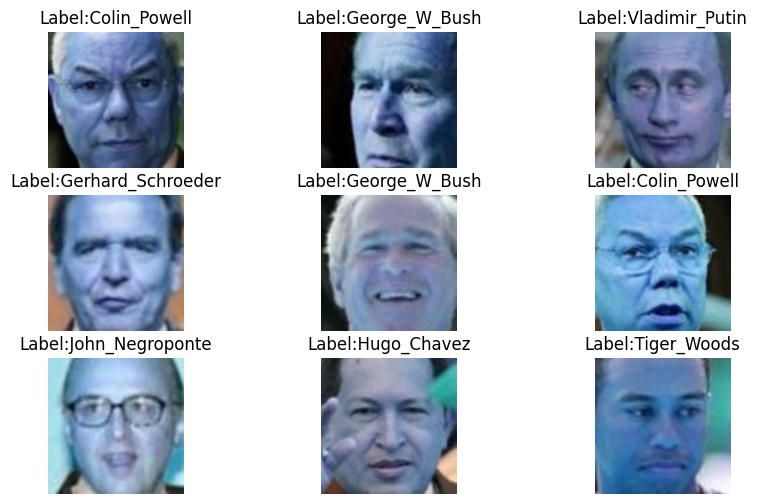

In [15]:
# Plot several images and labels
plt.figure(figsize=(10, 6))
data = iter(train_dataloader)
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    image, labels = next(data) # 9 next batch, plot the first image in each batch
    img = image[0].permute(1, 2, 0).squeeze()
    plt.imshow(img.numpy())
    plt.title('Label:' + str(name_list[labels[0]]))
    plt.axis('off')

### Task 1: Train a deep-learning Vision Transformer model for classification of images of celebrities

In [16]:
efficient_transformer = Linformer(
    dim=128, # dimension of the attention heads
    seq_len=49+1,  # length of input sequences: 7x7 patches + 1 class token
    depth=12, # number of stacked encoder blocks in the model
    heads=8, # number of attention heads
    k=64  # reduce the input dimension for efficiency
)

In [25]:
model_ViT = ViT(
    dim=128, # dimension of the attention heads
    image_size=224, # resolution of images
    patch_size=32, # size of image patches
    num_classes=62, # number of classes
    transformer=efficient_transformer, # the transformer backbone
    channels=3, # number of channels in images
)

In [26]:
model_ViT.to(device)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=3072, out_features=128, bias=True)
    (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0-11): 12 x ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): Fe

In [27]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model_ViT.parameters(), lr=1e-4)

In [28]:
# train the model and collect the training accuracy, training loss, val_accuracy, val_loss over all epochs

# training accuracy, training loss, val_accuracy, val_loss over all epochs
train_accuracy_epochs = []
train_loss_epochs = []
val_accuracy_epochs = []
val_loss_epochs = []

# train the model and evluate on validation dataset
epochs = 20
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_dataloader):
        data = data.to(device)
        label = label.to(device)

        output = model_ViT(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc.item() / len(train_dataloader)
        epoch_loss += loss.item() / len(train_dataloader)

    train_accuracy_epochs.append(epoch_accuracy)
    train_loss_epochs.append(epoch_loss )

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in val_dataloader:
            data = data.to(device)
            label = label.to(device)

            val_output = model_ViT(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc.item() / len(val_dataloader)
            epoch_val_loss += val_loss.item() / len(val_dataloader)

        val_accuracy_epochs.append(epoch_val_accuracy)
        val_loss_epochs.append(epoch_val_loss)


    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 1 - loss : 3.7498 - acc: 0.1646 - val_loss : 3.6399 - val_acc: 0.1719



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 2 - loss : 3.4712 - acc: 0.2033 - val_loss : 3.1907 - val_acc: 0.2452



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 3 - loss : 2.8131 - acc: 0.3488 - val_loss : 2.5316 - val_acc: 0.4040



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 4 - loss : 2.1810 - acc: 0.5133 - val_loss : 2.1119 - val_acc: 0.5464



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 5 - loss : 1.7223 - acc: 0.6562 - val_loss : 1.8328 - val_acc: 0.5946



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 6 - loss : 1.3628 - acc: 0.7602 - val_loss : 1.5709 - val_acc: 0.6698



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 7 - loss : 1.0407 - acc: 0.8468 - val_loss : 1.3923 - val_acc: 0.7246



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.7855 - acc: 0.9108 - val_loss : 1.1958 - val_acc: 0.7841



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.5771 - acc: 0.9453 - val_loss : 1.0907 - val_acc: 0.7902



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.4109 - acc: 0.9753 - val_loss : 0.9617 - val_acc: 0.8154



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.2881 - acc: 0.9899 - val_loss : 0.8939 - val_acc: 0.8282



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.2128 - acc: 0.9974 - val_loss : 0.8342 - val_acc: 0.8360



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.1599 - acc: 0.9993 - val_loss : 0.8094 - val_acc: 0.8312



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.1194 - acc: 1.0000 - val_loss : 0.7604 - val_acc: 0.8420



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.0948 - acc: 1.0000 - val_loss : 0.7518 - val_acc: 0.8380



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.0756 - acc: 1.0000 - val_loss : 0.7397 - val_acc: 0.8459



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.0635 - acc: 1.0000 - val_loss : 0.7324 - val_acc: 0.8410



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.0549 - acc: 1.0000 - val_loss : 0.7232 - val_acc: 0.8409



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.0478 - acc: 1.0000 - val_loss : 0.7154 - val_acc: 0.8428



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.0425 - acc: 1.0000 - val_loss : 0.7126 - val_acc: 0.8430



Text(0.5, 1.0, 'Training Loss and Validation Loss')

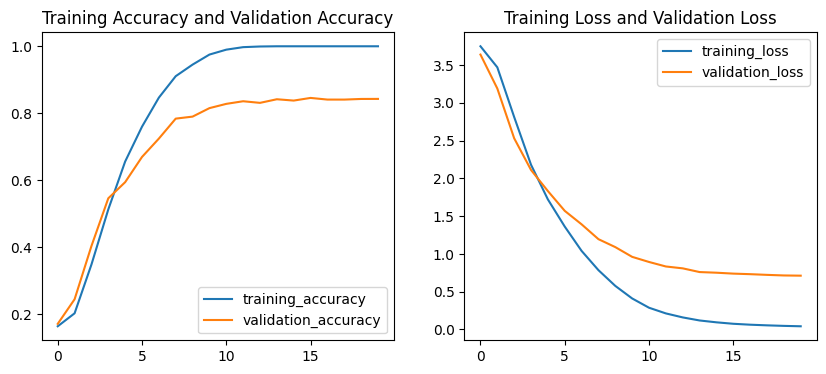

In [29]:
# plot training accuracy, validation accuracy, training loss, validation loss
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_accuracy_epochs, label='training_accuracy')
plt.plot(val_accuracy_epochs, label='validation_accuracy')
plt.legend()
plt.title('Training Accuracy and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(train_loss_epochs, label='training_loss')
plt.plot(val_loss_epochs, label='validation_loss')
plt.legend()
plt.title('Training Loss and Validation Loss')

In [30]:
# test the model
model_ViT.eval()  # it disables dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ViT(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

Test Accuracy of the model: 84.84270734032413 %


**Task 1 Report:**


|   Training Accuracy   |    Validation Accuracy   |   Test Accuracy|
|-----------------------|--------------------------|----------------|
|      1.0000           |        0.8430            |     0.8484     |



### Task 2: Create adversarial samples against Clarifai’s web ML model for celebrity recognition.

In [31]:
# define a function to generate PGD adversarial image

def PGD_attack(model, init_image, true_label, criterion, gamma, iteration, epsilon):
    '''
    This function generate the Project Gradient Descent adversarial image

    Parameters:
        model: the predict model
        init_image: the original image to be attacked
        true_label: the ground truth of the init_image
        criteirion: the loss function
        gamma: the parameter in PGD defintion formula
        iteration: how many iteration used to generate the adversarial image
        epsilon: the max pertubation

    Return: the adversarial image
    '''
    image = init_image.to(device)
    label = true_label.to(device)
    for i in range(iteration):

        # required gradient
        image.requires_grad = True

        # predict the image: forward and backward
        outputs = model(image)
        model.zero_grad()
        loss = criterion(outputs, label)
        loss.backward()

        # get the gradient and sign() of gradient
        sign_gradients = image.grad.sign()

        # Generate an adversarial image
        adv_image = image + gamma*sign_gradients

        # Calculate the added perturbation
        perturbation = adv_image - init_image

        # clip pertubation to [-epsilon, epsion]
        perturbation = torch.clamp(perturbation, min=-epsilon, max=epsilon)

        # Clip the pixel values to be in the [0, 1] range,
        # here image has updated to an adversarial image after each iteration
        image = torch.clamp(init_image + perturbation, min=0, max=1).detach()

        return image

In [56]:
# select test image 343
img_343 = Subset(test_dataset, [343])
img_343_dataloader = DataLoader(img_343, batch_size=1)

# get image and label of image 343
img_343_ViT, label_343_ViT = next(iter(img_343_dataloader))
img_343_ViT = img_343_ViT.to(device)
label_343_ViT = label_343_ViT.to(device)

# for target attack, select test image 2 as target label
img_2 = Subset(test_dataset, [2])
img_2_dataloader = DataLoader(img_2, batch_size=1)

# get image and label of image 343
img_2_ViT, label_2_ViT = next(iter(img_2_dataloader))
img_2_ViT = img_2_ViT.to(device)
label_2_ViT = label_2_ViT.to(device)

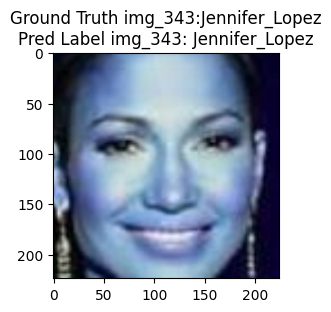

<ipython-input-57-6cea43f79999>:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,2)


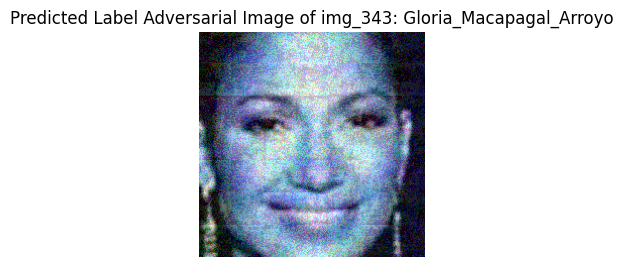

In [57]:
# predict the label of the image_343

pre_probs_343 = model_ViT(img_343_ViT)
_,pre_label = torch.max(pre_probs_343.data, 1)
plt.subplot(1,2,1)
plt.imshow(img_343_ViT.cpu().detach().squeeze().permute(1,2,0).numpy())
plt.title(f'Ground Truth img_343:{name_list[label_343_ViT]}\nPred Label img_343: {name_list[pre_label]}')
plt.show()
plt.axis('off')

# generate PGD adversarial image of image 343
for image_343, label_343 in img_343_dataloader:
    image_343 = image_343.to(device)
    label_343 = label_343.to(device)
    img_343_adv_10iter = PGD_attack(model=model_ViT,
                                init_image=image_343,
                                true_label=label_343,
                                criterion=criterion,
                                gamma=30./255,
                                iteration=500,
                                epsilon=100./255)


# predict and plot adversarial image
pre_probs_adv_img343 = model_ViT(img_343_adv_10iter)
_,pre_label_adv_img343 = torch.max(pre_probs_adv_img343, 1)
plt.subplot(1,2,2)
plt.imshow(img_343_adv_10iter.cpu().detach().squeeze().permute(1,2,0).numpy())
plt.title(f'Predicted Label Adversarial Image of img_343: {name_list[pre_label_adv_img343]}')
plt.axis('off')
plt.show()

# save the adversarial image
TF.to_pil_image(img_343_adv_10iter[0].cpu()).save('im5.jpg')


In [58]:
# use attack_PGD() to generate adversarial images for img_343

non_target_images_343 = []
target_images_343 = []

# define epsilons
epsilon_list =  [3/255, 5/255, 8/255, 20/255, 50/255, 80/255]

for i,eps in enumerate(epsilon_list):
    # apply non-targeted attack
    img_PGD_343_ntgt = projected_gradient_descent(
                                     model_fn=model_ViT,
                                     x=img_343_ViT,
                                     eps=eps,
                                     eps_iter=0.001,
                                     nb_iter=20,
                                     norm=np.inf,
                                    targeted=False)
    non_target_images_343.append(img_PGD_343_ntgt[0])
    TF.to_pil_image(img_PGD_343_ntgt[0].cpu()).save(f'img343_ntgt_{i}.jpg')
    # apply targeted attack
    img_PGD_343_tgt = projected_gradient_descent(
                            model_fn=model_ViT,
                            x=img_343_ViT,
                            eps=eps,
                            eps_iter=0.001,
                            nb_iter=20,
                            targeted=True,
                            norm=np.inf,
                            y=label_2_ViT)

    # Adding the output into the list
    target_images_343.append(img_PGD_343_tgt[0])
    TF.to_pil_image(img_PGD_343_ntgt[0].cpu()).save(f'img343_tgt_{i}.jpg')

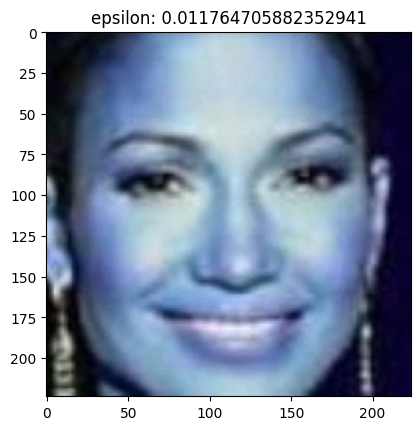

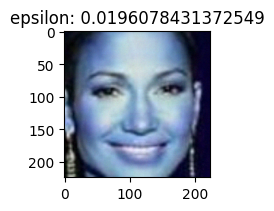

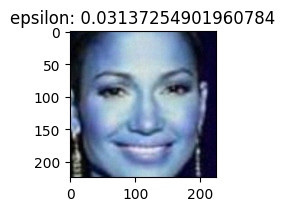

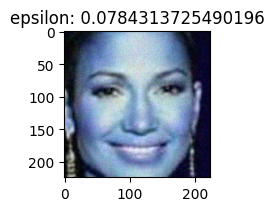

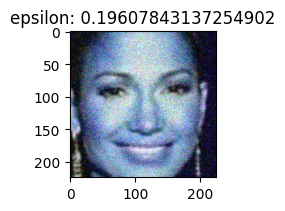

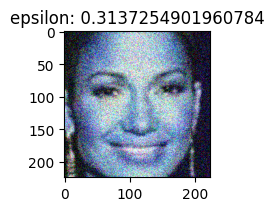

In [59]:
plt.figure(figsize=(16,16))
for i in range(len(epsilon_list)):
    plt.subplot(2, 3, i+1)
    plt.imshow(non_target_images_343[i].cpu().detach().permute(1,2,0).numpy())
    plt.title(f'epsilon: {epsilon_list[i]}')
    plt.show()

In [64]:
# select test image 442
img_442 = Subset(test_dataset, [442])
img_442_dataloader = DataLoader(img_442, batch_size=1)

# get image and label of image 442
img_442_ViT, label_442_ViT = next(iter(img_442_dataloader))
img_442_ViT = img_442_ViT.to(device)
label_442_ViT = label_442_ViT.to(device)

# for target attack, select test image 2 as target label
img_2 = Subset(test_dataset, [2])
img_2_dataloader = DataLoader(img_2, batch_size=1)

# get image and label of image 343
img_2_ViT, label_2_ViT = next(iter(img_2_dataloader))
img_2_ViT = img_2_ViT.to(device)
label_2_ViT = label_2_ViT.to(device)



In [65]:
# use attack_PGD() to generate adversarial images for img_442

non_target_images_442 = []
target_images_442 = []

# define epsilons
epsilon_list =  [3/255, 5/255, 8/255, 20/255, 50/255, 80/255]

for i,eps in enumerate(epsilon_list):
    # apply non-targeted attack
    img_PGD_442_ntgt = projected_gradient_descent(
                                     model_fn=model_ViT,
                                     x=img_442_ViT,
                                     eps=eps,
                                     eps_iter=0.001,
                                     nb_iter=20,
                                     norm=np.inf,
                                    targeted=False)
    non_target_images_442.append(img_PGD_442_ntgt[0])
    TF.to_pil_image(img_PGD_442_ntgt[0].cpu()).save(f'img442_ntgt_{i}.jpg')
    # apply targeted attack
    img_PGD_442_tgt = projected_gradient_descent(
                            model_fn=model_ViT,
                            x=img_442_ViT,
                            eps=eps,
                            eps_iter=0.001,
                            nb_iter=20,
                            targeted=True,
                            norm=np.inf,
                            y=label_2_ViT)

    # Adding the output into the list
    target_images_442.append(img_PGD_442_tgt[0])
    TF.to_pil_image(img_PGD_442_ntgt[0].cpu()).save(f'img442_tgt_{i}.jpg')

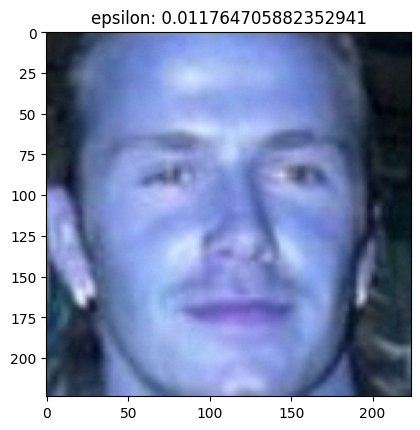

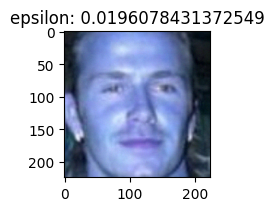

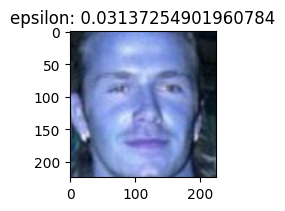

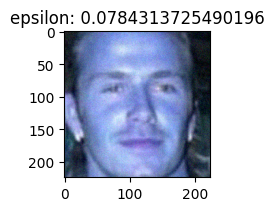

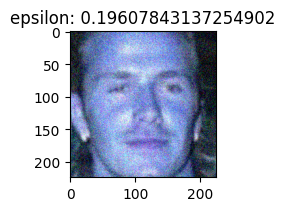

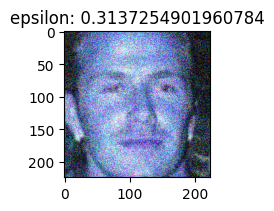

In [66]:
plt.figure(figsize=(16,16))
for i in range(len(epsilon_list)):
    plt.subplot(2, 3, i+1)
    plt.imshow(non_target_images_442[i].cpu().detach().permute(1,2,0).numpy())
    plt.title(f'epsilon: {epsilon_list[i]}')
    plt.show()

In [69]:
# select test image 53
img_53 = Subset(test_dataset, [53])
img_53_dataloader = DataLoader(img_53, batch_size=1)

# get image and label of image 53
img_53_ViT, label_53_ViT = next(iter(img_53_dataloader))
img_53_ViT = img_53_ViT.to(device)
label_53_ViT = label_53_ViT.to(device)


# for target attack, select test image 2 as target label
img_2 = Subset(test_dataset, [2])
img_2_dataloader = DataLoader(img_2, batch_size=1)
img_2_ViT = img_2_ViT.to(device)
label_2_ViT = label_2_ViT.to(device)

In [70]:
# use attack_PGD() to generate adversarial images for img_442

non_target_images_53 = []
target_images_53 = []

# define epsilons
epsilon_list =  [3/255, 5/255, 8/255, 20/255, 50/255, 80/255]

for i,eps in enumerate(epsilon_list):
    # apply non-targeted attack
    img_PGD_53_ntgt = projected_gradient_descent(
                                     model_fn=model_ViT,
                                     x=img_53_ViT,
                                     eps=eps,
                                     eps_iter=0.001,
                                     nb_iter=20,
                                     norm=np.inf,
                                    targeted=False)
    non_target_images_53.append(img_PGD_53_ntgt[0])
    TF.to_pil_image(img_PGD_442_ntgt[0].cpu()).save(f'img442_ntgt_{i}.jpg')
    # apply targeted attack
    img_PGD_53_tgt = projected_gradient_descent(
                            model_fn=model_ViT,
                            x=img_53_ViT,
                            eps=eps,
                            eps_iter=0.001,
                            nb_iter=20,
                            targeted=True,
                            norm=np.inf,
                            y=label_2_ViT)

    # Adding the output into the list
    target_images_53.append(img_PGD_53_tgt[0])
    TF.to_pil_image(img_PGD_53_ntgt[0].cpu()).save(f'img442_tgt_{i}.jpg')

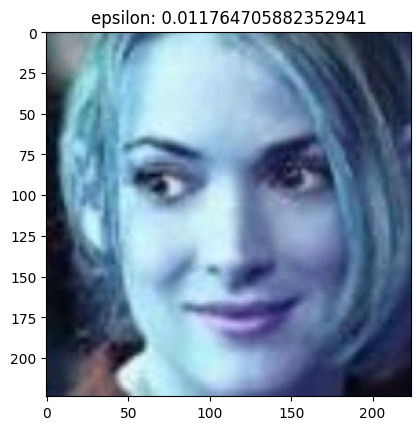

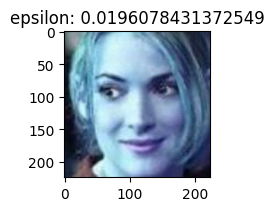

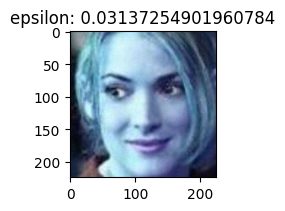

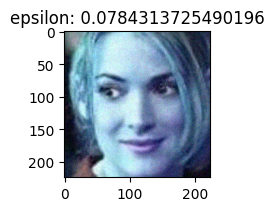

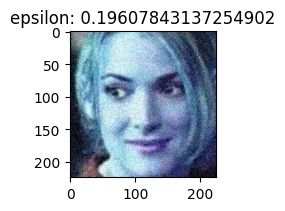

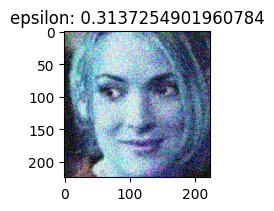

In [72]:
plt.figure(figsize=(16,16))
for i in range(len(epsilon_list)):
    plt.subplot(2, 3, i+1)
    plt.imshow(non_target_images_53[i].cpu().detach().permute(1,2,0).numpy())
    plt.title(f'epsilon: {epsilon_list[i]}')
    plt.show()

**The Non Targeted Result:**

<img src="NonTargetAttack_img_442_eps_5.png" width="450">

<img src="Non_TargetAttack_img442_esp50.png" width="450">

**Task2 Report:**


The truth label of test image 442 is "david backman". With epsilon = 5/255, the model can make correct predition. But when I increase epsilon to 50/255, the model misclassified image 442 as "orland bloom". Although clarifai model made wrong prediction, but the model also showed a very low confidence about this prediction. 


For targeted attack, I choose test image 2 as the targeted label. The truth label of test image 2 is 'Gloria_Macapagal_Arroyo'. I generated 5 targeted images for image 53, image 343 and image 442 repectively. None of these images achieved targeted image. Targeted attack is harder than non-targeted attack. I don't know the reason.